In [2]:
#setup
data_dir='../../Data/Weather'
# file_index='BBBSBBBB'
file_index='SSSSSSBB'
m='TOBS'

# Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [3]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [4]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [5]:
from pyspark import SparkContext
# sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [6]:
# data_dir='../../Data/Weather'
# file_index='BBBSBBBB'

In [7]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


In [8]:
measurements=['TOBS']

In [9]:
for name in measurements:
    eigvec = STAT[name]['eigvec']
    eigval = STAT[name]['eigval']


    # print sorted(eigval)

    pair = [(val, i) for i,val in enumerate(eigval)]

    pair.sort(key=lambda x: x[0])
    pair = pair[::-1]

    eigval_sorted = []
    eigvec_sorted = []
    for (val, i) in pair:
        eigval_sorted.append(val if val > 0 else 0)
#         eigval_sorted.append(val)
        eigvec_sorted.append(eigvec[:,i])
    STAT[name]['eigvec'] = (np.array(eigvec_sorted).T)
    STAT[name]['eigval'] = (np.array(eigval_sorted))

## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [10]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|     7|[40 56 E0 50 00 5...|1970.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|     3|[A0 56 30 55 80 5...|1971.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|    14|[80 54 A0 53 F0 5...|1973.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|    10|[40 56 20 50 30 5...|1974.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|     8|[30 54 30 54 30 5...|1975.0|SSSSSSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Create a matrix with all of the series

In [11]:
rows=df.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()

T=np.vstack(rows)
shape(T)

(1271, 365)

### Plot two time series
`SNWD` stands for `snow-depth`, which explains why it is zero during the summer

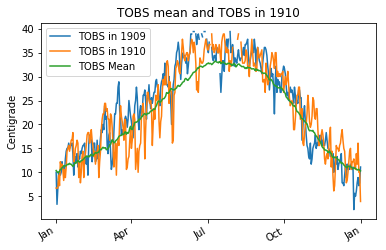

In [12]:
fig, ax = plt.subplots(figsize=(6,4));
YP=YearPlotter()
# print T[3:5]
YP.plot(T[3:5].transpose()/10,fig,ax,ylabel='',labels=['TOBS in 1909','TOBS in 1910'],title="TOBS mean and TOBS in 1910")
YP.plot(STAT[m]['Mean']/10,fig,ax,ylabel='Centigrade',label='TOBS Mean')
# fig.savefig('hw5_figures/TOBS_mean_1909_1910.png')

### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

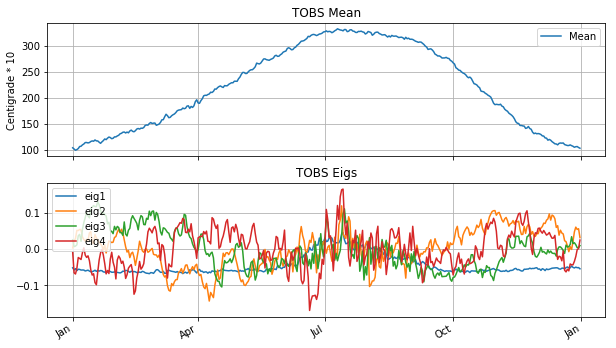

In [13]:
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=4
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],'Centigrade * 10',label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],'',title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])
# fig.savefig('hw5_figures/TOBS_compare.png')

### plot the percent of residual variance on average

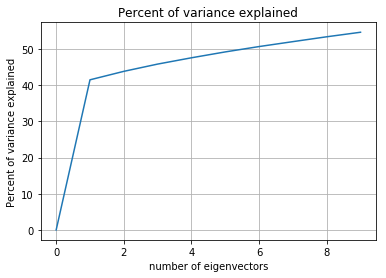

In [14]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

In [15]:
v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
i=1
eigen_decomp=Eigen_decomp(None,T[i],Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

residual normalized norm  after mean: 0.0318087713608
residual normalized norm  after mean + top eigs: [ 0.99529662  0.89930121  0.86963213  0.82296803]


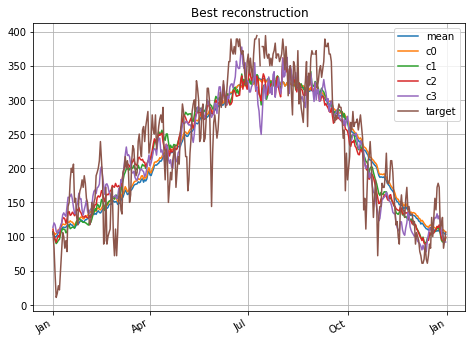

In [16]:
plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [17]:
rows=df.take(3)
L=[]
for row in rows:
    row_out=decompose(row,Mean,v)
    for field in ('res_mean','res_1','res_2','res_3'):
        print field,':',row_out[field],
    print

NameError: name 'decompose' is not defined

In [18]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [19]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 1271
after filter 1271


In [20]:
df3=df3.sort(df3.res_4,ascending=True)
rows=df3.take(12)
df3.show(10)


+-------------------+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
|            coeff_1|            coeff_2|            coeff_3|            coeff_4|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|              res_3|              res_4|           res_mean|    station|  total_var|undefs|              vector|  year|
+-------------------+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
| 1441.9621496516988| -99.11614260166023|-241.98375442573158|-112.32442160753439|    638.6|SSSSSSBB| 33.9792|-112.7403|       T

In [21]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10), name = ''):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
                    %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)
#     fig.savefig('hw5_figures/'+name+'.png')
    return None


In [22]:
df3=df3.sort(df3.res_4)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3','res_4').show(12)

+-------------------+-------------------+-------------------+-------------------+-------------------+
|           res_mean|              res_1|              res_2|              res_3|              res_4|
+-------------------+-------------------+-------------------+-------------------+-------------------+
|0.22102245166771514|0.22713588718050667|0.22348427872442406|0.20171881915044254|0.19702913275054898|
|0.24481585853903745|0.19888894656509754|0.19870070116280136| 0.1978116684858553|0.19765279910059358|
|0.15142575421832935|0.26519587079979023| 0.2320964654592012|0.20708561645792603|0.20696872632093463|
|0.20952937152063292|0.22407226769797545|0.22403680074708324| 0.2095855280255128|0.20889404968393951|
|0.07804423367816475|0.34637615435798613|0.25292550145895504|0.21442717088845237|0.21105574169871594|
|0.07363249770118238| 0.3665445694189184|0.26865284864952055|0.21830351406661208|0.21367200594190489|
|0.17383718813191396|0.27326480951836757| 0.2680815665566265| 0.2205950865173258| 

/root/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


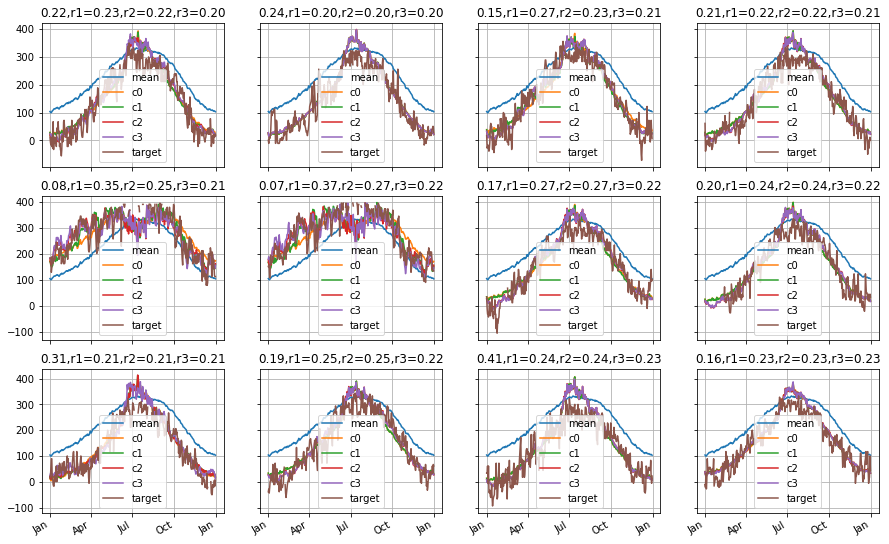

In [23]:
plot_recon_grid(rows,name = 'best_recon')

In [24]:
df3=df3.sort(df3.res_4,ascending=False)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3','res_4').show(12)

+--------------------+------------------+------------------+------------------+------------------+
|            res_mean|             res_1|             res_2|             res_3|             res_4|
+--------------------+------------------+------------------+------------------+------------------+
|0.026319104016279363|1.3694385527067752|1.3056297620575859|1.7430598779043938|1.7850642949630346|
|0.026665234975030806|1.3339373787519064|1.4466573671401215|1.5101393865522823|1.5773314866669497|
| 0.03185376569297341|1.0936539988141982| 1.275036598123772|1.4715967867753155|1.4937117783162959|
|0.026347180990659486|1.2702666310996031|1.5069713759282202|1.5437997798978604|1.4894483164762469|
|0.019866393123286412|0.9957152413158074|0.9914306086896661|1.0481741898551757|1.4244500184276023|
|0.024971560188014302|1.0574288587822254|1.0821385029430057|1.3688651769879538|1.3726162614185193|
|0.021211514483346645|1.1603777174035739|1.3085580823109546|1.2941806995078602|1.3442277912230813|
| 0.045871

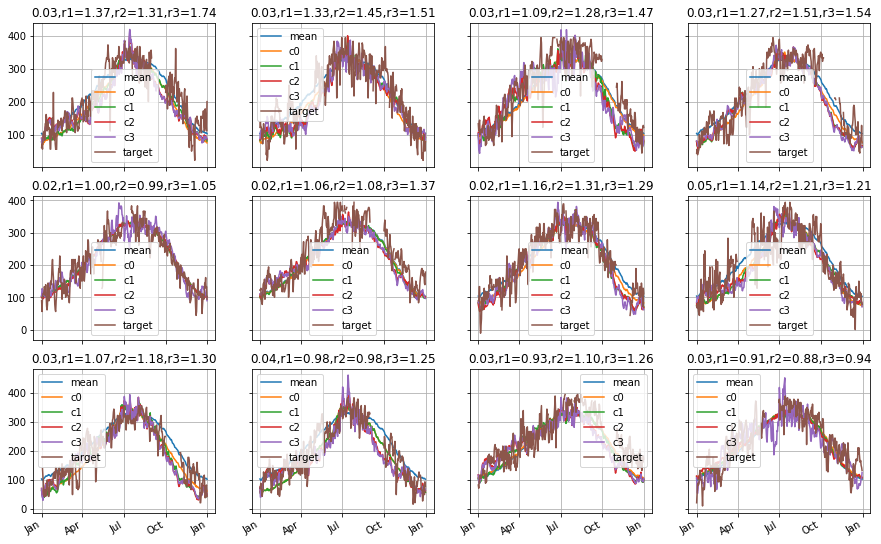

In [25]:
plot_recon_grid(rows,name = 'worst_recon')

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

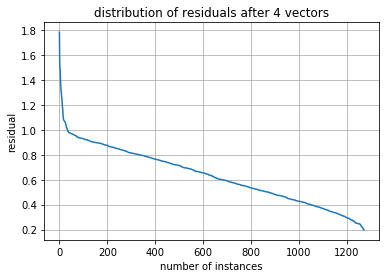

In [28]:
res4=df3.select('res_4').collect()
# print res4
R4=[r['res_4'] for r in res4]
plot(R4)
title('distribution of residuals after 4 vectors')
xlabel('number of instances')
ylabel('residual')
# ylim([0,1])
grid()
# savefig('hw5_figures/residual_instance.png')

In [39]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [40]:
!du -sh $data_dir/*.parquet

4.7M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
2.9M	../../Data/Weather/US_Weather_SSSSSSBB.parquet
2.4M	../../Data/Weather/decon_BBBSBBBB.parquet
2.4M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
3.2M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
3.2M	../../Data/Weather/decon_SSSSSSBB_TOBS.parquet
